In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from time import time

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
import json
import pandas as pd
import numpy as np
import re

# Function to load embeddings from JSON file and strip family prefix
def load_embeddings(file_path):
    with open(file_path, 'r') as f:
        raw_embeddings = json.load(f)
    
    # Strip family prefix and convert to numpy arrays
    embeddings = {}
    family_pattern = re.compile(r'^family\d+_')
    for key, value in raw_embeddings.items():
        stripped_key = family_pattern.sub('', key)  # Remove any 'familyX_' prefix
        embeddings[stripped_key] = np.array(value)
    
    return embeddings

# Load embeddings
try:
    embeddings = load_embeddings('/Users/utkarsh/MMLI/equicat/develop_op/final_molecule_embeddings.json')
    print(f"Loaded embeddings for {len(embeddings)} entities")
    print("Sample keys from embeddings:", list(embeddings.keys()))
except FileNotFoundError:
    print("Error: 'embeddings.json' file not found. Please ensure it's in the correct directory.")
    embeddings = {}
except Exception as e:
    print(f"Error loading embeddings: {str(e)}")
    embeddings = {}

# Load Y data
try:
    Y_df = pd.read_csv('/Users/utkarsh/MMLI/equicat/science/Y_DATA.csv', dtype={
        'catalyst_id': str,
        'imine_id': str,
        'thiol_id': str,
        'product_id': str
    })
    print(f"Loaded Y data with {len(Y_df)} rows")
    print("Sample rows from Y_df:")
    print(Y_df.head())
except FileNotFoundError:
    print("Error: 'Y_DATA.csv' file not found. Please ensure it's in the correct directory.")
    Y_df = pd.DataFrame()

# Check for missing IDs
missing_ids = set()
for _, row in Y_df.iterrows():
    for id_type in ['catalyst_id', 'imine_id', 'thiol_id', 'product_id']:
        if row[id_type] not in embeddings:
            missing_ids.add(row[id_type])

print(f"Number of missing IDs: {len(missing_ids)}")
print("Sample of missing IDs:", list(missing_ids)[:10] if missing_ids else "None")

# Additional checks
if embeddings:
    # Check for consistency in embedding dimensions
    embedding_sizes = set(emb.shape for emb in embeddings.values())
    if len(embedding_sizes) > 1:
        print("Warning: Inconsistent embedding sizes detected.")
        print("Unique embedding sizes:", embedding_sizes)
    else:
        print(f"All embeddings have consistent size: {next(iter(embedding_sizes))}")

    # Check for any potential data issues
    nan_keys = [key for key, emb in embeddings.items() if np.isnan(emb).any()]
    inf_keys = [key for key, emb in embeddings.items() if np.isinf(emb).any()]
    
    if nan_keys:
        print(f"Warning: NaN values found in embeddings for keys: {nan_keys[:10]}")
    if inf_keys:
        print(f"Warning: Inf values found in embeddings for keys: {inf_keys[:10]}")

# Print summary
print("\nSummary:")
print(f"Total embeddings loaded: {len(embeddings)}")
print(f"Total rows in Y_df: {len(Y_df)}")
print(f"Total missing IDs: {len(missing_ids)}")

Loaded embeddings for 835 entities
Sample keys from embeddings: ['54_vi', '177_i', '83_vi', '15_i', '8_i', '73_vi', '134_i', '230_vi', '131_vi', '263_vi', '109_vi', '282_i', '319_i', '1_i', '70_vi', '332_i', '388_vi', '135_vi', '270_i', '394_vi', '276_i', '62_vi', '129_i', '212_vi', '124_vi', '289_i', '331_i', '216_i', '223_vi', '353_i', '341_vi', '80_i', '363_i', '52_vi', '366_i', '365_i', '60_vi', '320_i', '121_i', '324_vi', '285_vi', '151_i', '380_vi', '326_i', '353_vi', '124_i', '338_vi', '254_i', '147_vi', '98_i', '272_i', '286_i', '397_i', '322_vi', '87_vi', '107_i', '312_i', '150_vi', '347_vi', '261_vi', '315_i', '92_i', '120_vi', '186_vi', '103_i', '148_i', '155_i', '362_i', '347_i', '48_i', '122_i', '361_vi', '50_vi', '30_vi', '192_i', '203_i', '16_vi', '244_i', '120_i', '119_vi', '72_i', '44_i', '130_i', '385_vi', '271_i', '12_vi', '402_vi', '303_i', '185_i', '303_vi', '268_vi', '279_i', '392_i', '340_vi', '394_i', '396_i', '198_vi', '33_vi', '358_vi', '114_i', '250_i', '25_i

In [3]:
# Create X data using embeddings for catalyst, imine, thiol, and product
X_data = []
Y_data = []

for _, row in Y_df.iterrows():
    catalyst_id = row['catalyst_id']
    imine_id = row['imine_id']
    thiol_id = row['thiol_id']
    product_id = row['product_id']
    
    if all(id in embeddings for id in [catalyst_id, imine_id, thiol_id, product_id]):
        combined_embedding = np.concatenate([
            embeddings[catalyst_id],
            embeddings[imine_id],
            embeddings[thiol_id],
            embeddings[product_id]
        ])
        X_data.append(combined_embedding)
        Y_data.append(row['selectivity_ddGact_kcal'])
    else:
        print(f"Missing embedding for reaction: {row['reaction_handle']} - Missing IDs: {[id for id in [catalyst_id, imine_id, thiol_id, product_id] if id not in embeddings]}")

X_df = pd.DataFrame(X_data)
Y_series = pd.Series(Y_data)

print(f"Created dataset with {len(X_df)} samples and {X_df.shape[1]} features")
print("Sample rows from X_df:")
print(X_df.head())

if len(X_df) == 0:
    print("Error: No matching data found. Please check if the IDs in Y_DATA.csv match the keys in the embeddings file.")
    exit()

print(f"Created dataset with {len(X_df)} samples and {X_df.shape[1]} features")

Missing embedding for reaction: 181_i_1_A - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_1_B - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_1_C - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_1_D - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_1_E - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_2_A - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_2_B - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_2_C - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_2_D - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_2_E - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_3_A - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_3_B - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_3_C - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_3_D - Missing IDs: ['181_i']
Missing embedding for reaction: 181_i_3_E - Missing IDs: ['181

In [5]:
seed = 213557 // 2
np.random.seed(seed)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.8, random_state=seed)

f_select_model = RandomForestRegressor(n_estimators=1000, n_jobs=64, random_state=1234)

pipe_random = Pipeline(steps=[
    ('preprocess', VarianceThreshold(1e-3)),
    ('feature_selection', SelectFromModel(f_select_model, max_features=30)),
    ('model', GradientBoostingRegressor(n_estimators=500, learning_rate=0.01))
])

param_dict = {
    'model__learning_rate': np.logspace(-4, 0, 20),
    'model__subsample': np.linspace(0.5, 1.0, 10),
    # 'model__colsample_bytree': np.linspace(0.1, 1.0, 10),
    # 'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
    # 'model__min_child_weight': np.linspace(1, 10, 10),
    # 'model__gamma': np.linspace(0, 1, 10),
    'model__min_weight_fraction_leaf': (np.random.uniform(0.0, .5,20)),
    'model__max_depth': [3,4,5,6,7,8,9,10,None],
    'model__max_features': (np.random.uniform(0.01, .99,20)),
    'model__max_leaf_nodes': [10,100,1000,None],
    'model__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

search = RandomizedSearchCV(pipe_random, cv=5, param_distributions=param_dict,
                            n_iter=100, n_jobs=64, verbose=3, refit='neg_mean_absolute_error',
                            scoring=['neg_mean_absolute_error', 'r2'])

t0 = time()
print("Fitting started...")
search = search.fit(X_train, Y_train)
print(f"Fitting took {time() - t0:0.3f}s.")

best_model = search.best_estimator_

print("Best parameters found:")
for param, value in search.best_params_.items():
    print(f"{param}: {value}")

Fitting started...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END model__learning_rate=0.23357214690901212, model__max_depth=None, model__max_features=0.8457183688932298, model__max_leaf_nodes=100, model__min_weight_fraction_leaf=0.4342227728259146, model__n_estimators=500, model__subsample=0.7222222222222222; neg_mean_absolute_error: (test=-0.225) r2: (test=0.838) total time=  55.4s
[CV 2/5] END model__learning_rate=0.23357214690901212, model__max_depth=None, model__max_features=0.8457183688932298, model__max_leaf_nodes=100, model__min_weight_fraction_leaf=0.4342227728259146, model__n_estimators=500, model__subsample=0.7222222222222222; neg_mean_absolute_error: (test=-0.280) r2: (test=0.811) total time=  56.0s
[CV 3/5] END model__learning_rate=0.23357214690901212, model__max_depth=None, model__max_features=0.8457183688932298, model__max_leaf_nodes=100, model__min_weight_fraction_leaf=0.4342227728259146, model__n_estimators=500, model__subsample=0.722222222

In [6]:
Y_pred_train = best_model.predict(X_train)
Y_pred_test = best_model.predict(X_test)

train_r2 = r2_score(Y_train, Y_pred_train)
train_mae = mean_absolute_error(Y_train, Y_pred_train)
test_r2 = r2_score(Y_test, Y_pred_test)
test_mae = mean_absolute_error(Y_test, Y_pred_test)

print(f"Train R^2: {train_r2:.5f}, train MAE: {train_mae:.5f}")
print(f"Test R^2: {test_r2:.5f}, test MAE: {test_mae:.5f}")

Train R^2: 0.96476, train MAE: 0.08628
Test R^2: 0.87228, test MAE: 0.17627


In [7]:
def predict_ddg(catalyst_id, imine_id, thiol_id, product_id):
    if all(id in embeddings for id in [catalyst_id, imine_id, thiol_id, product_id]):
        combined_embedding = np.concatenate([
            embeddings[catalyst_id],
            embeddings[imine_id],
            embeddings[thiol_id],
            embeddings[product_id]
        ])
        return best_model.predict([combined_embedding])[0]
    else:
        return "One or more components not found in embeddings"

# Example usage
example_row = Y_df.iloc[3]
print(f"Prediction for reaction {example_row['reaction_handle']}: "
      f"{predict_ddg(example_row['catalyst_id'], example_row['imine_id'], example_row['thiol_id'], example_row['product_id']):.4f}")

Prediction for reaction 1_i_1_D: 1.1072


Plotting results...
EQUICAT Prediction
Train R^2: 0.96476, train MAE: 0.08628
Test R^2: 0.87228, test MAE: 0.17627


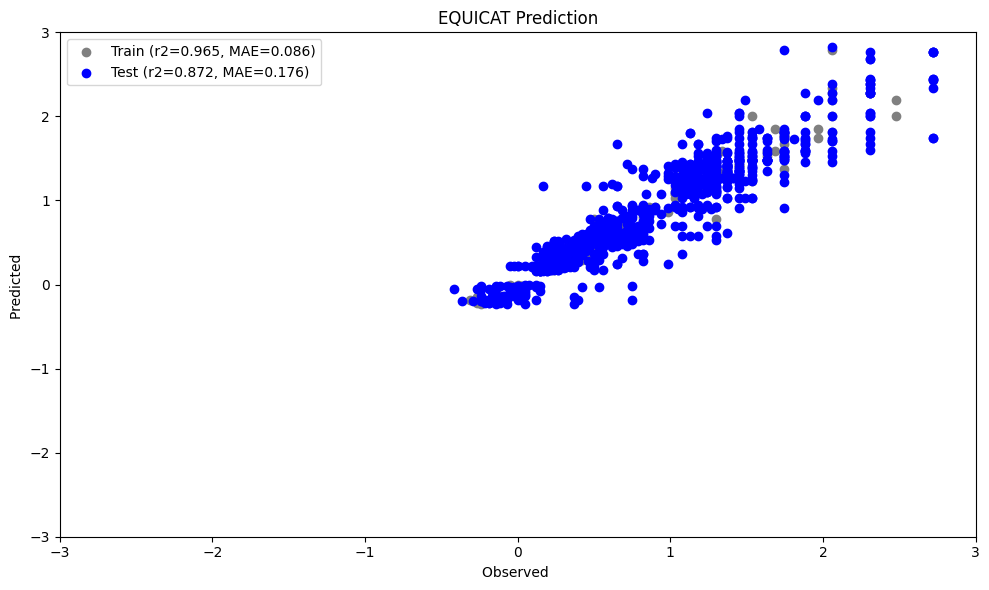

In [8]:
import matplotlib.pyplot as plt

def plot_and_print(estimator, X_train, Y_train, X_test, Y_test, title, verbose=1, file_dpi=800):
    predicted_train = estimator.predict(X_train)
    r2_train = r2_score(Y_train, predicted_train)
    mae_train = mean_absolute_error(Y_train, predicted_train)

    predicted_test = estimator.predict(X_test)
    r2_test = r2_score(Y_test, predicted_test)
    mae_test = mean_absolute_error(Y_test, predicted_test)

    if verbose:
        print(title)
        print(f"Train R^2: {r2_train:0.5f}, train MAE: {mae_train:0.5f}")
        print(f"Test R^2: {r2_test:0.5f}, test MAE: {mae_test:0.5f}")
    
    fig, ax = plt.subplots(figsize=(10, 6))

    train_plot = ax.scatter(
        Y_train,
        predicted_train,
        color="gray",
        label=f"Train (r2={r2_train:0.3f}, MAE={mae_train:0.3f})"
    )

    test_plot = ax.scatter(
        Y_test,
        predicted_test,
        color="blue",
        label=f"Test (r2={r2_test:0.3f}, MAE={mae_test:0.3f})"
    )

    ax.set_title(title)
    ax.set_xlabel("Observed ")
    ax.set_ylabel("Predicted ")
    ax.set_ylim(-3, 3)
    ax.set_xlim(-3, 3)
        
    plt.legend()
    plt.tight_layout()
    plt.savefig(title + ".png", dpi=file_dpi)
    plt.show()
    plt.close()

# Plot and print results
print("Plotting results...")
plot_and_print(best_model, X_train, Y_train, X_test, Y_test, "EQUICAT Prediction")

EQUICAT Prediction with Confidence Intervals
Train R^2: 0.96476, train MAE: 0.08628
Test R^2: 0.87228, test MAE: 0.17627


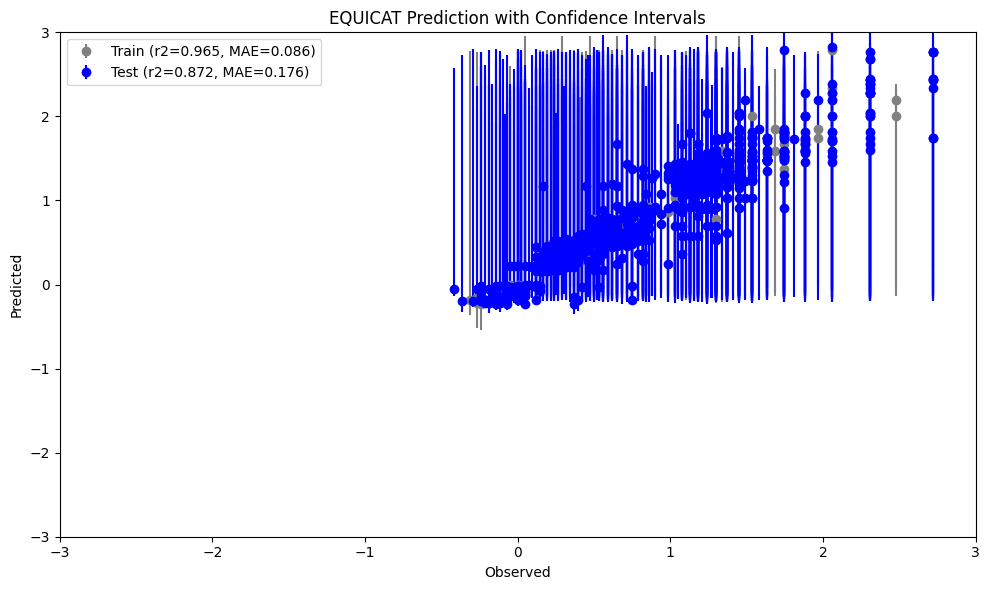

In [9]:
# Step 1: Define the bootstrap_predictions function
def bootstrap_predictions(estimator, X, n_bootstraps=100, ci=95):
    """
    Generates bootstrap predictions for each sample in X and calculates confidence intervals.
    """
    X = np.array(X)  # Ensure X is a NumPy array for indexing
    boot_preds = []
    
    for _ in range(n_bootstraps):
        # Resample the training data with replacement
        X_bootstrap_indices = np.random.choice(range(len(X)), size=len(X), replace=True)
        X_bootstrap = X[X_bootstrap_indices]
        boot_preds.append(estimator.predict(X_bootstrap))

    # Calculate lower and upper bounds for the confidence interval
    lower_bound = np.percentile(boot_preds, (100 - ci) / 2, axis=0)
    upper_bound = np.percentile(boot_preds, 100 - (100 - ci) / 2, axis=0)

    return lower_bound, upper_bound

# Step 2: Generate confidence intervals for train and test predictions
Y_train_lower, Y_train_upper = bootstrap_predictions(best_model, X_train)
Y_test_lower, Y_test_upper = bootstrap_predictions(best_model, X_test)

# Modify the plotting function to handle confidence intervals with non-negative error bounds
def plot_and_print_with_ci(estimator, X_train, Y_train, X_test, Y_test, title,
                           Y_train_lower, Y_train_upper, Y_test_lower, Y_test_upper,
                           verbose=1, file_dpi=800):
    predicted_train = estimator.predict(X_train)
    r2_train = r2_score(Y_train, predicted_train)
    mae_train = mean_absolute_error(Y_train, predicted_train)

    predicted_test = estimator.predict(X_test)
    r2_test = r2_score(Y_test, predicted_test)
    mae_test = mean_absolute_error(Y_test, predicted_test)

    if verbose:
        print(title)
        print(f"Train R^2: {r2_train:0.5f}, train MAE: {mae_train:0.5f}")
        print(f"Test R^2: {r2_test:0.5f}, test MAE: {mae_test:0.5f}")

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training data with confidence intervals (abs to ensure non-negative errors)
    ax.errorbar(Y_train, predicted_train, 
                yerr=[np.abs(predicted_train - Y_train_lower), np.abs(Y_train_upper - predicted_train)],
                fmt='o', color="gray", label=f"Train (r2={r2_train:0.3f}, MAE={mae_train:0.3f})")

    # Plot test data with confidence intervals
    ax.errorbar(Y_test, predicted_test, 
                yerr=[np.abs(predicted_test - Y_test_lower), np.abs(Y_test_upper - predicted_test)],
                fmt='o', color="blue", label=f"Test (r2={r2_test:0.3f}, MAE={mae_test:0.3f})")

    ax.set_title(title)
    ax.set_xlabel("Observed")
    ax.set_ylabel("Predicted")
    ax.set_ylim(-3, 3)
    ax.set_xlim(-3, 3)

    plt.legend()
    plt.tight_layout()
    plt.savefig(title + ".png", dpi=file_dpi)
    plt.show()
    plt.close()

# Plot with confidence intervals
plot_and_print_with_ci(best_model, X_train, Y_train, X_test, Y_test, "EQUICAT Prediction with Confidence Intervals",
                       Y_train_lower, Y_train_upper, Y_test_lower, Y_test_upper)
